# 导入数据

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os 
path="/content/drive/My Drive/Colab Notebooks/NLP/Project/"
os.chdir(path)

In [0]:
!pip uninstall tensorflow

Uninstalling tensorflow-2.2.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0


In [0]:
!pip install tensorflow==1.13.1

     |████████████████████████████████| 92.5MB 92kB/s 
     |████████████████████████████████| 3.2MB 34.5MB/s 
     |████████████████████████████████| 368kB 32.5MB/s 
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0


In [0]:
from albert_zh.extract_feature import BertVector

In [0]:
import pandas as pd
train=pd.read_json("train_clean.txt")
train.head()

,text_clean,anno_text,anno_text2
0,"[N, I, C, H, 预, 后, 与, 其, 出, 血, 类, 型, 有, 关, 。, ...","[disease, disease, disease, disease, 0, 0, 0, ...","[disease, disease, disease, disease, 0, 0, 0, ..."
1,"[I, C, H, 的, 预, 后, 与, 其, 发, 病, 年, 龄, 、, 病, 因, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[①, 有, 明, 显, 感, 染, 病, 灶, ，, 如, 脐, 炎, 、, 肺, 炎, ...","[0, 0, 0, 0, 0, 0, subject, subject, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, subject, subject, 0, 0, 0, ..."
3,"[颅, 内, 压, 明, 显, 增, 高, 时, 可, 用, 呋, 塞, 米, 每, 次, ...","[item, item, item, decorate, decorate, subject...","[item, item, item, decorate, decorate, subject..."
4,"[治, 疗, 过, 程, 中, 脑, 脊, 液, 检, 查, 好, 转, ，, 而, 体, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ite...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ite..."


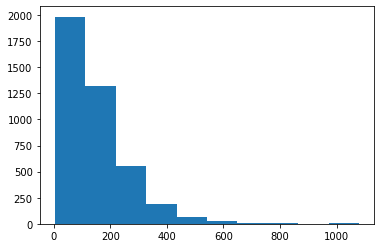

<class 'list'>


In [0]:
import matplotlib.pyplot as plt
totalNumWords = [len(one_text) for one_text in train["text_clean"]]
plt.hist(totalNumWords)
plt.show()
print(type(train["text_clean"][0]))

In [0]:
maxlen=400
min(totalNumWords),max(totalNumWords)

(4, 1080)

In [0]:
tags=[]
for anno in train["anno_text2"]:
    #print(anno)
    for i in anno:
        if i not in tags:
            tags.append(i)

n_tags=len(tags)
len(tags)

7

# 格式化输入

In [0]:
from future.utils import iteritems
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}
print(len(tag2idx))

7


In [0]:
# adding albert提取特征
bert_model = BertVector(pooling_strategy="NONE", max_seq_len=maxlen)
f = lambda text: bert_model.encode([text])["encodes"][0]

I:BERT_VEC:[graph:opt: 48]:model config: /content/drive/My Drive/Colab Notebooks/NLP/Project/albert_zh/albert_tiny/albert_config_tiny.json
I:BERT_VEC:[graph:opt: 54]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

embedding_lookup_factorized. factorized embedding parameterization is used.
ln_type: postln
old structure of transformer.use: transformer_model,which use post-LN


I:BERT_VEC:[graph:opt:128]:load parameters from checkpoint...
I:BERT_VEC:[graph:opt:130]:freeze...
I:BERT_VEC:[graph:opt:133]:optimize...
I:BERT_VEC:[graph:opt:144]:write graph to a tmp file: ./tmp_graph11


In [0]:
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
# adding bert初始化数据
def read_data(path):
    filepd = pd.read_json(path)
    # albert encoding
    sentences = ["".join(wordlist) for wordlist in filepd["text_clean"]]
    x = []
    print("start albert encoding")
    processor_bar = tqdm(sentences)
    for bar, sentence in zip(processor_bar, sentences):
        processor_bar.set_description("Processing")
        x.append(f(sentence))
    x = np.array(x)
    print("end albert encoding")
    tag2idx = {t: i for i, t in enumerate(tags)}
    idx2tag = {v: k for k, v in iteritems(tag2idx)}
    y = [[tag2idx[w] for w in s] for s in filepd["anno_text2"]]  # 单标签
    y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["0"])
    y = [to_categorical(i, num_classes=n_tags) for i in y]
    y = np.array(y)
    print(np.shape(x), np.shape(y))
    return x, y

# 读取训练集，验证集和测试集数据
train_x, train_y = read_data("train_clean.txt")
dev_x, dev_y = read_data("dev_clean.txt")
test_x, test_y = read_data("test_clean.txt")



Using TensorFlow backend.
Processing:   0%|          | 0/4164 [00:00<?, ?it/s]

start albert encoding


Processing: 100%|██████████| 4164/4164 [15:21<00:00,  4.52it/s]


end albert encoding
(4164, 400, 312) (4164, 400, 7)


Processing:   0%|          | 0/311 [00:00<?, ?it/s]

start albert encoding


Processing: 100%|██████████| 311/311 [02:46<00:00,  1.87it/s]


end albert encoding
(311, 400, 312) (311, 400, 7)


Processing:   0%|          | 0/787 [00:00<?, ?it/s]

start albert encoding


Processing: 100%|██████████| 787/787 [05:55<00:00,  2.22it/s]


end albert encoding
(787, 400, 312) (787, 400, 7)


# 模型


In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-sveee3m5
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-sveee3m5
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=d9c6f729ca2666f9ffc2fc06eb7a5cbeb7877a437d1ee25351663cdfcdfe4690
  Stored in directory: /tmp/pip-ephem-wheel-cache-0yprqccy/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import keras as k
from keras_contrib.layers import CRF
# Bert Embedding Layer
bert_output = Input(shape=(maxlen,312,), name="bert_output")
# BI-LSTM Layer
lstm = Bidirectional(LSTM(units=128, return_sequences=True), name="bi_lstm")(bert_output)
drop = Dropout(0.1, name="dropout")(lstm)
# TimeDistributed Layer
dense = TimeDistributed(Dense(n_tags, activation="relu"), name="time_distributed")(drop)
# Crf Layer
crf = CRF(n_tags)
out = crf(dense)
model = Model(inputs=bert_output, outputs=out)

#Optimiser
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

model.summary()

# Saving the best model only
filepath="ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the best model
history = model.fit(train_x, train_y, validation_data=(dev_x, dev_y), batch_size=32, verbose=1, epochs=20, callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert_output (InputLayer)     (None, 400, 312)          0         
_________________________________________________________________
bi_lstm (Bidirectional)      (None, 400, 256)          451584    
_________________________________________________________________
dropout (Dropout)            (None, 400, 256)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 400, 7)            1799      
_________________________________________________________________
crf_2 (CRF)                  (None, 400, 7)            119       
Total params: 453,502
Trainable params: 453,502
Non-trainable params: 0
_________________________________________________________________
Train on 4164 samples, validate on 311 samples
Epoch 1/20
4164/4164 [==============================] - 344s 83ms/step -

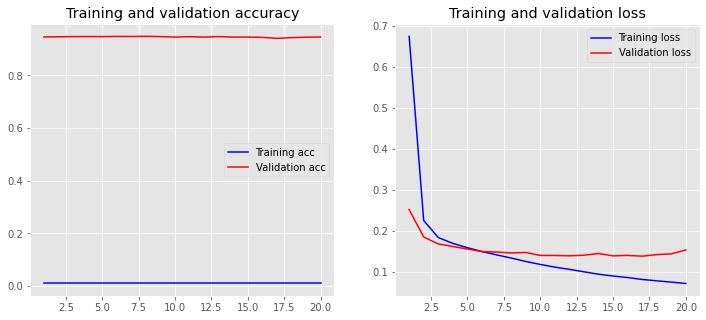

In [0]:
# Plot the graph 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [0]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
test_pred = model.predict(test_x, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(test_y)
print(len(test_labels), len(pred_labels))

787/787 [==============================] - 21s 27ms/step
787 787


In [0]:
! pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=fa5702f3a6f2feef05e55638e0253ab0d20fb872fe2c0e2f3fa4847600c88130
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [0]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.2%}".format(f1_score(test_labels, pred_labels)))

F1-score: 11.47%


In [0]:
print(test_labels[0])
print(pred_labels[0])
t=0
for i in range(400):
    if test_labels[0][i]==pred_labels[0][i]:
        t+=1
print(t)
print(precision_score(test_labels[0], pred_labels[0]))
print(recall_score(test_labels[0], pred_labels[0]))
print(classification_report(test_labels[0], pred_labels[0]))

['disease', 'disease', 'disease', '0', '0', '0', '0', '0', '0', 'body', 'body', 'body', 'body', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'subject', 'subject', '0', '0', 'body', 'body', 'subject', 'subject', 'subject', 'subject', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

In [0]:
! pip install sklearn_crfsuite

     |████████████████████████████████| 747kB 4.9MB/s 


In [0]:
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.95      0.99      0.97    295258
        body       0.41      0.18      0.25      3855
    decorate       0.36      0.07      0.12      1854
     disease       0.31      0.12      0.17      3017
   frequency       0.00      0.00      0.00       151
        item       0.27      0.01      0.01       557
     subject       0.50      0.14      0.22     10108

    accuracy                           0.94    314800
   macro avg       0.40      0.21      0.25    314800
weighted avg       0.92      0.94      0.92    314800

